In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
def make_train_tests(DIR="../input/"):
    train=pd.read_csv(DIR+"/stage2_final_train.csv",index_col=0)
    test=pd.read_csv(DIR+"/stage2_final_test.csv",index_col=0)
    labels=train['Class']
    train=train.drop("Class",axis=1)
    assert (train.columns==test.columns).all()
    return (train.values.astype(np.float32),labels.values-1),test.values.astype(np.float32)

In [3]:
(train,labels),test=make_train_tests()
train.shape,labels.shape,test.shape

((3689, 6500), (3689,), (986, 6500))

In [4]:
train.nbytes/1024*2.,test.nbytes/1024*2.

(187332.0, 50070.0)

In [5]:
pd.Series(labels).value_counts()

6    1054
3     751
0     662
1     498
5     297
4     267
2      96
8      43
7      21
dtype: int64

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb

/home/spark/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
xgb.__version__

'0.6'

In [8]:
def shuffle_XY(X,y):
    idx=np.random.permutation(range(len(y)))
    return X[idx],y[idx]
def shuffle_XY2(X,y):
    idx=np.random.choice(range(len(y)),replace=True,size=len(y))
    return X[idx],y[idx]

In [9]:
def make_model(i,trainx,trainy,colsample_bytree=1,max_depth=4,subsample=1,
                                    learning_rate=0.03,min_child_weight=1):
        models=[]
        X,y=shuffle_XY(trainx,trainy)
        kf = KFold(n_splits=5)
        scores=[]
        for train_idx, test_idx in kf.split(X):
            X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
            #X_train,y_train=shuffle_XY2(X_train,y_train)
            eval_set = [(X_train, y_train),(X_test, y_test)]
            clf = xgb.XGBClassifier(colsample_bytree=colsample_bytree,
                                    max_depth=max_depth,
                                    subsample=subsample,
                                    learning_rate=learning_rate,
                                    min_child_weight=min_child_weight,
                                    n_estimators=2000,
                                    objective="multi:softmax")
            print X_train.shape,X_test.shape
            #print clf.get_params()
            clf.fit(X_train, y_train,eval_metric="mlogloss",early_stopping_rounds=50, eval_set=eval_set, verbose=50)         
            models.append(clf)
            pred=clf.predict_proba(X_test,ntree_limit=clf.best_ntree_limit)
            scores.append(log_loss(y_test,pred,labels=range(9)))
            print log_loss(y_train,clf.predict_proba(X_train,ntree_limit=clf.best_ntree_limit),labels=range(9)), scores[-1]
        print scores
        print i, "mean loss", np.mean(scores),np.std(scores)
        #return models
        return np.mean(scores),np.std(scores),models

In [10]:
param={'subsample': 0.8, 'learning_rate': 0.01, 'colsample_bytree': 0.5, 'max_depth': 3, 'min_child_weight': 2}

In [11]:
def run_once(param,train,labels,test):
    colsample_bytree=param["colsample_bytree"]
    max_depth=param["max_depth"]
    subsample=param["subsample"]
    learning_rate=param["learning_rate"]
    min_child_weight=param["min_child_weight"]
    scores=[]
    print param
    
    s,_,models=make_model(-1,train,labels,
                   colsample_bytree=colsample_bytree,
                   max_depth=max_depth,
                   subsample=subsample,
                   learning_rate=learning_rate,
                   min_child_weight=min_child_weight)
    print "score:", s
    pred=np.mean([m.predict_proba(test) for m in models],axis=0)
    return s,pred

In [12]:
#a=run_once(param,train,labels,test)

In [13]:
import findspark
findspark.init()

In [14]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
conf = SparkConf()
conf.set('spark.executor.cores',1)
conf.set('spark.executor.instances',1) 
conf.set('spark.speculation','true') 
conf.set('spark.driver.memory','40G') 
conf.set('spark.executor.memory','45G') 

#conf.set('spark.cores.max',15)     
conf.setAppName("spark")
conf.setMaster("spark://192.168.0.11:7077")
#conf.setMaster("local")

In [15]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc=spark.sparkContext

In [16]:
from time import sleep

In [17]:
data=sc.broadcast((train,labels,test))
sleep(20)

In [ ]:
N=500
a=sc.parallelize(range(N),N)
sleep(20)
a.getNumPartitions()

500

In [ ]:
results=a.map(lambda u: run_once(param,data.value[0],data.value[1],data.value[2])).collect()

In [ ]:
import cPickle as pickle

In [ ]:
pickle.dump((param,results), open('xgb_predict_2.pkl','wb'))

In [ ]:
sc.stop()

In [23]:
files=["xgb_predict_1.pkl",'xgb_predict_2.pkl']

In [24]:
pickled= reduce(lambda u,v: u+v, [pickle.load(open(fname))[1] for fname in files])

In [25]:
len(pickled)

600

In [27]:
u[1][0]

array([  3.08081154e-02,   7.62322778e-03,   3.63692199e-03,
         8.88493717e-01,   1.62223913e-02,   4.42655943e-02,
         6.61117584e-03,   6.72217109e-04,   1.66661793e-03], dtype=float32)

(0.72536738335514939, 0.0045943999539356309)

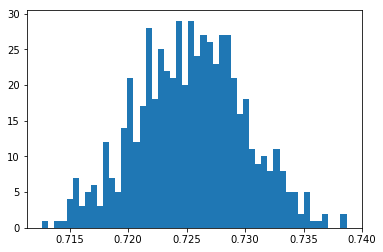

In [26]:
plt.hist([u[0] for u in pickled],bins=50);
np.mean([u[0] for u in pickled]),np.std([u[0] for u in pickled])

(0.8778249, 0.0062661455)

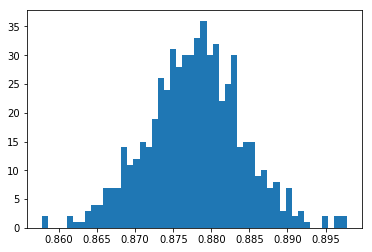

In [27]:
plt.hist([u[1][0][3] for u in pickled],bins=50);
np.mean([u[1][0][3] for u in pickled]),np.std([u[1][0][3] for u in pickled])

(0.033339925, 0.0020476065)

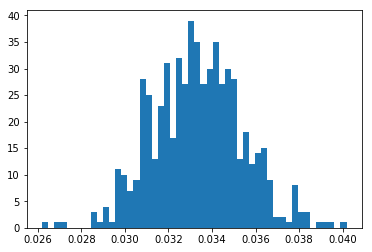

In [28]:
plt.hist([u[1][0][0] for u in pickled],bins=50);
np.mean([u[1][0][0] for u in pickled]),np.std([u[1][0][0] for u in pickled])

In [31]:
np.log(0.87),np.log(0.91)

(-0.13926206733350766, -0.09431067947124129)

In [29]:
len(pickled)

600

In [30]:
mean_preds=np.mean([u[1] for u in pickled],0)

In [31]:
mean_preds.shape

(986, 9)

In [32]:
mean_preds.sum(1).mean()

1.0

In [34]:
test=pd.read_csv("../input/stage2_final_test.csv",index_col=0)

In [35]:
sample_sub=pd.read_csv("../input/stage2_sample_submission.csv",index_col=0)

In [36]:
submission=pd.DataFrame(mean_preds,index=test.index)
submission.columns=sample_sub.columns

In [37]:
submission

class1    class2    class3    class4    class5    class6    class7  \
ID                                                                          
1    0.033340  0.008870  0.003746  0.877825  0.017841  0.047883  0.007684   
2    0.983814  0.003147  0.000532  0.004288  0.000609  0.004100  0.002865   
3    0.026092  0.119875  0.015743  0.099962  0.045662  0.056986  0.628843   
4    0.070038  0.228513  0.003452  0.115073  0.006918  0.090189  0.481535   
5    0.002559  0.203161  0.003304  0.006724  0.008017  0.004229  0.770474   
6    0.068453  0.039245  0.009526  0.248204  0.041887  0.513473  0.073469   
7    0.012992  0.259729  0.006352  0.014954  0.015982  0.003993  0.682791   
8    0.207051  0.147388  0.007022  0.311507  0.028098  0.104098  0.190923   
9    0.247428  0.014640  0.008429  0.681223  0.013231  0.012093  0.019572   
10   0.003107  0.005374  0.200080  0.008453  0.052253  0.003146  0.726051   
11   0.029263  0.156022  0.005000  0.057560  0.072344  0.005976  0.670410   
12   0.001682  0.881530  0.002198  0.001784  0.002413  0.001767  0.107144   
13   0.935546  0.001418  0.002046  0.003859  0.051282  0.002574  0.001724   
14   0.002977  0.062263  0.004349  0.003131  0.005074  0.002472  0.918567   
15   0.045991  0.427739  0.008695  0.077366  0.027504  0.164806  0.230252   
16   0.752511  0.160667  0.003905  0.045568  0.009101  0.005734  0.009914   
17   0.129272  0.237845  0.002566  0.157897  0.020936  0.054728  0.390885   
18   0.072472  0.236560  0.010300  0.163901  0.026019  0.022208  0.464341   
19   0.037595  0.100789  0.004132  0.025757  0.044145  0.010107  0.774171   
20   0.081123  0.318157  0.005639  0.154679  0.017334  0.153217  0.266490   
21   0.004070  0.066159  0.001991  0.003276  0.004930  0.002894  0.915162   
22   0.005048  0.009851  0.003731  0.949769  0.012290  0.002739  0.003919   
23   0.606538  0.045980  0.011161  0.141246  0.058429  0.046736  0.078983   
24   0.001502  0.295941  0.001336  0.002298  0.002216  0.003387  0.690110   
25   0.190001  0.028430  0.006929  0.611311  0.010330  0.011301  0.138013   
26   0.003367  0.004167  0.004370  0.002352  0.009122  0.005755  0.969396   
27   0.043649  0.268656  0.002711  0.304585  0.007154  0.016505  0.351116   
28   0.033310  0.375417  0.007496  0.072073  0.016739  0.006376  0.482671   
29   0.007709  0.388914  0.006774  0.518235  0.017649  0.010010  0.048747   
30   0.091065  0.427763  0.003336  0.102731  0.023053  0.077094  0.273022   
..        ...       ...       ...       ...       ...       ...       ...   
957  0.005879  0.002046  0.010327  0.967788  0.007366  0.002399  0.003492   
958  0.009414  0.286700  0.009324  0.008073  0.042749  0.003376  0.637712   
959  0.957423  0.003969  0.004148  0.013770  0.010897  0.003280  0.004419   
960  0.360513  0.016717  0.004950  0.306494  0.027057  0.034081  0.241980   
961  0.104867  0.154358  0.004881  0.225007  0.032764  0.024847  0.451162   
962  0.001439  0.022504  0.002257  0.002038  0.003018  0.000999  0.966738   
963  0.919318  0.003589  0.000433  0.061684  0.000829  0.004289  0.008146   
964  0.209421  0.315470  0.047141  0.046069  0.120956  0.049391  0.183008   
965  0.036772  0.809128  0.003618  0.041983  0.035307  0.033652  0.037669   
966  0.049854  0.401080  0.006850  0.056190  0.025878  0.114614  0.316169   
967  0.324654  0.000827  0.001503  0.664767  0.004690  0.001472  0.001337   
968  0.008437  0.586867  0.004088  0.004653  0.011046  0.004547  0.378708   
969  0.679562  0.005088  0.002750  0.284859  0.013436  0.004899  0.006775   
970  0.182065  0.241520  0.019163  0.095014  0.055372  0.014404  0.381321   
971  0.713539  0.217321  0.002982  0.037884  0.008980  0.005027  0.009010   
972  0.474782  0.058519  0.003460  0.323555  0.013673  0.041543  0.081505   
973  0.750975  0.164091  0.005653  0.029693  0.024022  0.006035  0.013425   
974  0.009913  0.118248  0.008417  0.033518  0.020501  0.004720  0.800197   
975  0.041154  0.265099  0.004227  0.161975  0.017307  0.034211  0.471790   
976

In [38]:
submission.sum(1).mean()

1.0

In [39]:
submission.to_csv("../input/sub_xgb.csv")